source: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5694755/pdf/fimmu-08-01500.pdf

In [4]:
import pandas as pd
import numpy as np
from scipy import mean
import scipy.stats as st
from random import sample
import matplotlib.pyplot as plt
import seaborn as sns

#HPV_repes = ["01_1",
#             "02",
#             "03",
#             "05",
#             "06",
#             "07_1",
#             "08",
#             "09_1",
#             "10",
#             "11_1",
#             "12",
#             "13",
#             "14",
#             "15",
#             "16",
#             "17_1",
#             "18",
#             "19",
#             "20_1",
#             "21",
#             "22",
#             "23",
#             "24",
#             "25",
#             "26",
#             "27",
#             "28",
#             "29",
#             "30",
#             "31",
#             "32",
#             "33",
#             "34_1",
#             "35",
#             "36",
#             "37_1",
#             "38",
#             "39",
#             "41",
#             "42",
#             "43",
#             "44_1",
#             "45",
#             "46",
#             "47",
#             "48",
#             "49_1",
#             "50" ]
HPV_repes = ["01_1",
             "02",
             "30" ]

repertoire_list = list()
for i in HPV_repes :
    print( "Loading {} dataset...".format( i ) )
    temp_df = pd.read_csv( "/Users/natem/Dropbox (Scripps Research)/Personal/Code/Python/Vercingetorix/input/sampleExport.2019-06-17_11-06-30/{}.tsv".format( i ), sep="\t", usecols=[1,2,7,14,21,38] )
    temp_df = temp_df[temp_df.sequenceStatus == "In"]
    temp_df = temp_df.sort_values( ["count (templates/reads)"], ascending=False )
    temp_df = temp_df[:1000]
    temp_df["sample"] = i

    repertoire_list.append( temp_df )

full_table = pd.concat( repertoire_list, ignore_index=True )
full_table.columns = ["aminoAcid", "count", "v_segment", "d_segment", "j_segment", "sequenceStatus", "sample" ]

HPV_metadata = pd.read_csv(
    "/Users/natem/Dropbox (Scripps Research)/Personal/Code/Python/Vercingetorix/input/SampleOverview_06-18-2019_4-56-01_PM.tsv",
    sep="\t",
    index_col=0 )
HPV_metadata = HPV_metadata.sort_index()
HPV_metadata = HPV_metadata.loc[HPV_repes]
print( "Loaded Metadata...")


Loading 01_1 dataset...
Loading 02 dataset...
Loading 30 dataset...
Loaded Metadata...


In [7]:
full_table.head()

,aminoAcid,count,v_segment,d_segment,j_segment,sequenceStatus,sample,freq
0,CASSPDRGRGYTF,240628,TCRBV14-01,TCRBD01-01,TCRBJ01-02,In,01_1,0.260063
1,CASSPDSDNEQFF,30138,TCRBV18-01,TCRBD01-01,TCRBJ02-01,In,01_1,0.032572
2,CASSGRTGEEAFF,27630,TCRBV09-01,TCRBD01-01,TCRBJ01-01,In,01_1,0.029862
3,CASSFSGWFSPLHF,16753,TCRBV05-01,TCRBD01-01,TCRBJ01-06,In,01_1,0.018106
4,CASSQTSSTDTQYF,16206,TCRBV04-01,unresolved,TCRBJ02-03,In,01_1,0.017515


# JSD Testing

In [52]:
from Bio.SubsMat.MatrixInfo import blosum62
from Bio import Align

# Set Aligner parameters according to Yokota et al. Also just pretty standard protein alignment.
# Any matrix will do, I should find some way of determining what matrix is best.
aligner = Align.PairwiseAligner()
aligner.substitution_matrix = blosum62
aligner.mode = "local"
aligner.open_gap_score = -10
aligner.extend_gap_score = -1

print( "\nPairwise alignment performed with following parameters: " )
print( "\t Substitution Matrix: {}".format( "BLOSUM62" ) )
print( "\t Mode: {}".format( "Local" ) )
print( "\t Open Gap Penalty: {}".format( aligner.open_gap_score ) )
print( "\t Extend Gap Penalty: {}".format( aligner.extend_gap_score ) )

# Create an empty matrix with length equal to the number of clonotypes in repertoire.
pairwise_distances = np.zeros( ( len( full_table ), len( full_table ) ) )

# Compare every clonotype with every other clonotype.
total = full_table["aminoAcid"] 
for i, sequenceA in enumerate( full_table["aminoAcid"] ):
    for j, sequenceB in enumerate( full_table["aminoAcid"] ):
        # The distance from A to B should be equal to the distance from B to A, and we don't want
        # to calculate that twice.
        if j >= i:
            pairwise_distance = aligner.score( sequenceA, sequenceB )
            pairwise_distances[j,i] = pairwise_distance
            pairwise_distances[i,j] = pairwise_distance
    if i % 1000 == 0:
        print( "Distance Calculations: {} of {} sequences completed".format( i, len( full_table["aminoAcid"] ) ) )


        
print( "\nConverting distance matrix into dissimilarity matrix..." )
dissimilarity_matrix = np.zeros( ( len( pairwise_distances), len( pairwise_distances ) ) )
for i, row in enumerate( pairwise_distances ):
    for j, distance in enumerate( row ):
        if j >= i:
            dissimilarity = 1 - ( ( 2 * distance ) / ( pairwise_distances[i,i] + pairwise_distances[j,j] ) )

            if dissimilarity < 0:
               print( "Error: {} vs {}, D: {}".format( full_table["aminoAcid"][i], full_table["aminoAcid"][j], dissimilarity ) )

            dissimilarity_matrix[j,i] = dissimilarity
            dissimilarity_matrix[i,j] = dissimilarity
    if i % 1000 == 0:
        print( "Dissimilarity Calculations: {} of {} sequences completed".format( i, len( full_table["aminoAcid"] ) ) )

print( "\nSaving dissimilarity matrix...")
#dissimilarity_matrix.to_csv( "dissimilarity_matrix.csv", index=False )


Pairwise alignment performed with following parameters: 
	 Substitution Matrix: BLOSUM62
	 Mode: Local
	 Open Gap Penalty: -10.0
	 Extend Gap Penalty: -1.0
Distance Calculations: 0 of 300 sequences completed

Converting distance matrix into dissimilarity matrix...
Dissimilarity Calculations: 0 of 300 sequences completed

Saving dissimilarity matrix...


In [53]:
from sklearn.manifold import TSNE
X_embedded = TSNE( n_components=2, random_state=42, metric='precomputed', verbose=True ).fit_transform( dissimilarity_matrix )
X_embedded.shape

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 300 samples in 0.000s...
[t-SNE] Computed neighbors for 300 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 300 / 300
[t-SNE] Mean sigma: 0.250963
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.390594
[t-SNE] KL divergence after 1000 iterations: 0.776417


(300, 2)

In [54]:
tsne_df = pd.DataFrame( X_embedded, columns=["TSNE_1", "TSNE_2" ] )
tsne_df["aminoAcid"] = full_table["aminoAcid"]
tsne_df["sample"] = full_table["sample"]
tsne_df["count"] = full_table["count"]

#list( HPV_metadata.loc[tsne_df["sample"]]["CIN3_Status"] == "Positive" )
tsne_df["CIN3_Status"] = list( HPV_metadata.loc[tsne_df["sample"]]["CIN3_Status"] == "Positive" )

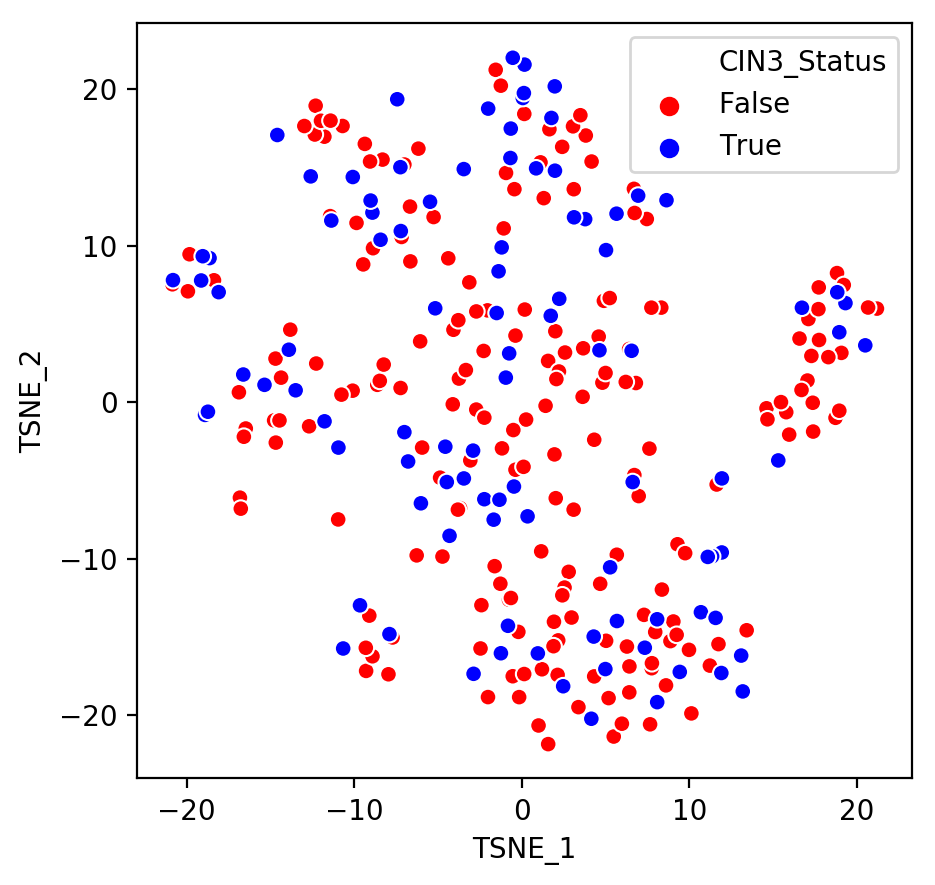

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

#Literature Data
fig, ax = plt.subplots( figsize=(5, 5), dpi=200 )
g1 = sns.scatterplot( x="TSNE_1", y="TSNE_2", hue="CIN3_Status", palette=["r", "b"], data=tsne_df )
plt.show()

In [57]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

# discretized the embedded space with 400 bins along each axis.
x_bin_min = min( tsne_df["TSNE_1"]) - ( max( tsne_df["TSNE_1"] ) - min( tsne_df["TSNE_1"] ) ) / 10
x_bin_max = max( tsne_df["TSNE_1"]) + ( max( tsne_df["TSNE_1"] ) - min( tsne_df["TSNE_1"] ) ) / 10
y_bin_min = min( tsne_df["TSNE_2"]) - ( max( tsne_df["TSNE_2"] ) - min( tsne_df["TSNE_2"] ) ) / 10
y_bin_max = max( tsne_df["TSNE_2"]) + ( max( tsne_df["TSNE_2"] ) - min( tsne_df["TSNE_2"] ) ) / 10

digitized_tsne = st.binned_statistic_2d( x=tsne_df["TSNE_1"],
                                        y=tsne_df["TSNE_2"], 
                                        values=tsne_df["count"], 
                                        bins=400,
                                        statistic="sum", 
                                        range = [[x_bin_min, x_bin_max], [y_bin_min, y_bin_max]] )
tsne_df["binnumber"] = digitized_tsne.binnumber

print( "\nSaving t-SNE Embeddings..." )
#tsne_df.to_csv( "", index=False )

# Parameters for optimization
params = { 'bandwidth': np.logspace(-1, 1, 20) }
grid = GridSearchCV( KernelDensity( algorithm="kd_tree", kernel="exponential" ), params, cv=5, iid=False, refit=False, verbose=1 )

xx, yy = np.mgrid[x_bin_min:x_bin_max:400j, y_bin_min:y_bin_max:400j]
positions = np.vstack( [xx.ravel(), yy.ravel()] )
values = digitized_tsne.statistic.ravel()

# Peform the kernel density estimate, being sure to remove bins which contain
# no clones. This greatly reduces complexity of problem.

print( "\nOptimizing bandwidth parameter for Kernel Density Estimation..." )
grid.fit( positions[:,values!=0].T, sample_weight=values[values!=0] )

# Utilize the best estimator. Oddly enough this was 10 last time I checked. So quite different from
# the 2.33 which is arrived at with point-wise data. Higher number of points I guess.
kernel = grid.best_estimator_

print( "Optimal bandwidth value is {}".format( grid.best_params_["bandwidth"] ) )


Saving t-SNE Embeddings...

Optimizing bandwidth parameter for Kernel Density Estimation...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    6.2s finished


AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

In [60]:
grid.best_params_["bandwidth"]

6.158482110660261

In [247]:
kernel_list = list()
count = 1
for i in HPV_repes:
    temp_digitized = st.binned_statistic_2d( x=tsne_df[tsne_df["sample"] == i]["TSNE_1"],
                                            y=tsne_df[tsne_df["sample"] == i]["TSNE_2"], 
                                            values=tsne_df[tsne_df["sample"] == i]["count"], 
                                            bins=400,
                                            statistic="sum", 
                                            range = [[x_bin_min, x_bin_max], [y_bin_min, y_bin_max]] )
    
    xx, yy = np.mgrid[x_bin_min:x_bin_max:400j, y_bin_min:y_bin_max:400j]
    positions = np.vstack( [xx.ravel(), yy.ravel()] )
    values = temp_digitized.statistic.ravel()
    temp_kernel = KernelDensity( algorithm="kd_tree", kernel="exponential", bandwidth=grid.best_params_["bandwidth"] )
    temp_kernel.fit( positions[:,values!=0].T, sample_weight=values[values!=0] )
    kernel_output = temp_kernel.score_samples( positions.T )
    kernel_list.append( kernel_output )
    print( "Calculated Kernal for {} of {} samples.".format( count, len( kernel_list ) ) )
    count += 1

In [15]:
from scipy.spatial.distance import jensenshannon

jsd_matrix = np.zeros( ( len( HPV_repes ), len( HPV_repes ) ) )
for i, pdfA in enumerate( kernel_list ):
    for j, pdfB in enumerate( kernel_list ):
        # The distance from A to B should be equal to the distance from B to A, and we don't want
        # to calculate that twice.
        if j >= i:
            jsd = jensenshannon( pdfA, pdfB)
            jsd_matrix[j,i] = jsd
            jsd_matrix[i,j] = jsd
    print( "Jensen-Shannon Divergence calculated for: {} of {} samples completed".format( i, len( kernel_list ) ) )

            

NameError: name 'kernel_list' is not defined

In [252]:
jsd_df = pd.DataFrame( jsd_matrix, columns=HPV_repes, index=HPV_repes )
jsd_df.to_csv( "" )

,01_1,02,30
01_1,0.000000,0.017193,0.017341
02,0.017193,0.000000,0.023577
30,0.017341,0.023577,0.000000


In [16]:
jsd_df = pd.read_csv( "input/jsd.csv", index_col=0 )
jsd_df = np.sqrt( jsd_df )

/Users/natem/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  This is separate from the ipykernel package so we can avoid doing imports until


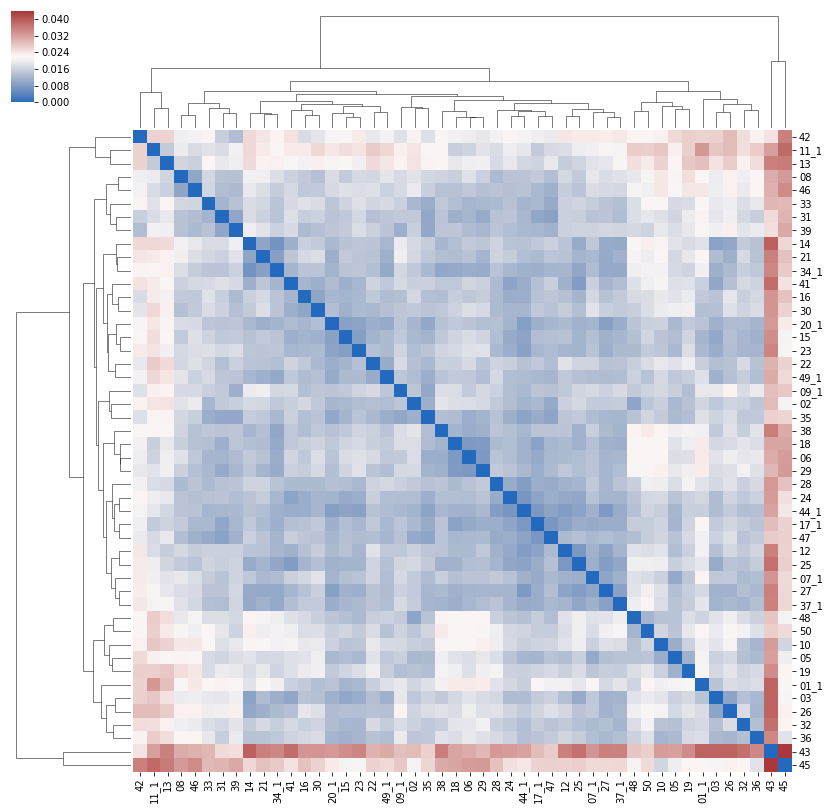

In [19]:
import scipy.cluster.hierarchy as hc

linkage = hc.linkage( jsd_df, method="complete" )

sns.clustermap( jsd_df,
               row_linkage=linkage,
               col_linkage=linkage,
               cmap="vlag",
              figsize=(14,14))

In [256]:
HPV_metadata

,total_reads,total_productive_reads,fraction_productive,total_rearrangements,productive_rearrangements,productive_clonality,max_productive_frequency,locus,Age,CIN3_Status,Infection,Smoker_Status,Pregnancies
sample_name,,,,,,,,,,,,,
01_1,2269988,1811467,0.7980,30063,25210,0.2185,0.132836,TCRB,48 Years,Negative,Human Papillomavirus (HPV),Never Smoked,3+
02,2338191,1877545,0.8030,55348,46444,0.1252,0.038255,TCRB,35 Years,Negative,Human Papillomavirus (HPV),Never Smoked,3+
30,5169233,4374048,0.8462,73449,59582,0.2263,0.064638,TCRB,25 Years,Positive,Human Papillomavirus (HPV),Never Smoked,3+


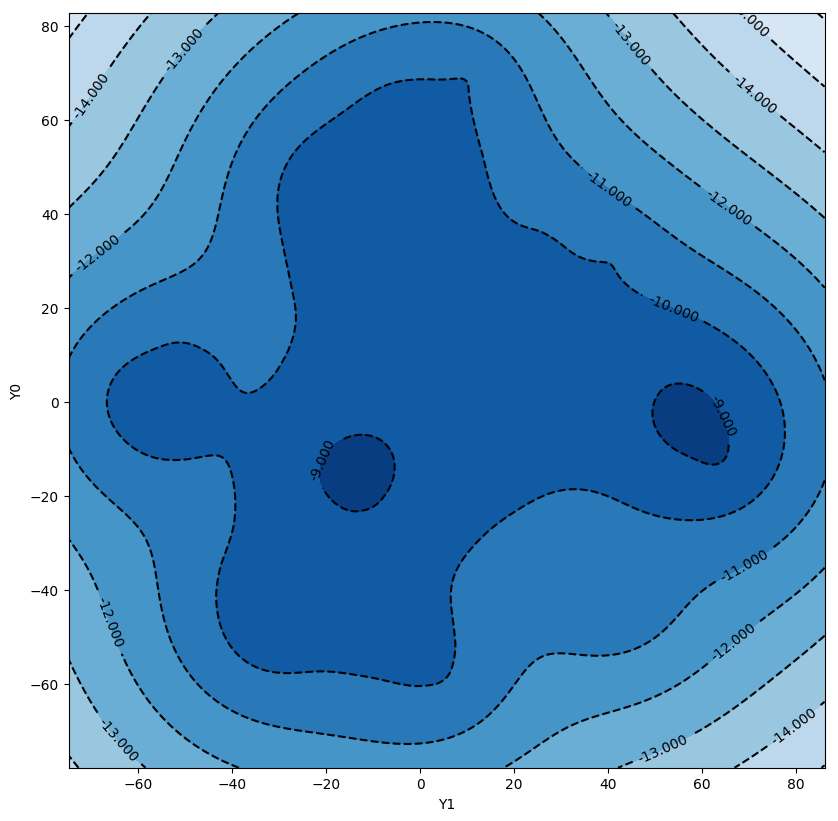

In [183]:
fig = plt.figure( figsize=( 10, 10 ), dpi=100 )
ax = fig.gca()
ax.set_xlim( x_bin_min, x_bin_max )
ax.set_ylim( y_bin_min, y_bin_max )
# Contourf plot
cfset = ax.contourf( xx, yy, f, cmap='Blues')
# Or kernel density estimate plot instead of the contourf plot
ax.imshow( np.rot90( f ), cmap='Blues', extent=[x_bin_min, x_bin_max, y_bin_min, y_bin_max] )
# Contour plot
cset = ax.contour( xx, yy, f, colors='k' )
# Label plot
ax.clabel( cset, inline=1, fontsize=10 )
ax.set_xlabel( 'Y1' )
ax.set_ylabel( 'Y0' )

plt.show()

# Morisita Index

In [10]:
# Add frequency column to full_table. 
full_table["freq"] = full_table.groupby( "sample" ).transform( lambda x : ( x / x.sum() ) ) 


len( full_table.groupby(["sample", 'aminoAcid','v_segment', "d_segment", "j_segment"]).size().reset_index().rename(columns={0:'count'} ) )

# Calculate Simpson Index of sample
#np.log( np.power( np.power( full_table[full_table["sample"]=="01_1"]["freq"], 2 ).sum(), -1 ) )

3000


2991

In [31]:
def simpson_index( clone_list ):
    return np.log( np.power( np.power( clone_list["freq"], 2 ).sum(), -1 ) )
    
simpson_indexes = full_table.groupby( ["sample"] ).apply( simpson_index )

In [42]:
morisita_index = np.zeros( ( len( simpson_indexes ), len( simpson_indexes ) ) )

for i, sampleA in enumerate( simpson_indexes.index ):
    for j, sampleB in enumerate( simpson_indexes.index ):
        if j >= i:
            print( "{} - {}".format( sampleA, sampleB ) )

01_1 - 01_1
01_1 - 02
01_1 - 30
02 - 02
02 - 30
30 - 30


In [56]:
partition2 = full_table.loc[ full_table["sample"]=="02" ]

partition2.groupby( ['aminoAcid','v_segment', "d_segment", "j_segment"] )["count"].sum().index.get_level_values()

TypeError: get_level_values() missing 1 required positional argument: 'level'

In [34]:
def power_geometric_index( sampleA, sampleB, alpha, beta=None, corrected=False ): 
        # You can do funky things with alpha and beta to create a 3D overlap profile instead of a 2D one.
        if beta is None:
            beta = alpha
        
        sumA = sum( self.repertoireA_dict.values() )
        sumB = sum( self.repertoireB_dict.values() )
        
        if not corrected:
            
            term1 = 0.0
            term2 = 0.0
            term3 = 0.0
            term4 = 0.0
            
            for i in set( self.repertoireA_dict.keys() ).intersection( self.repertoireB_dict.keys() ):
                term1 += math.pow( self.repertoireA_dict[i] / sumA, alpha ) * math.pow( self.repertoireB_dict[i] / sumB, beta )
                term2 += math.pow( self.repertoireB_dict[i] / sumB, alpha ) * math.pow( self.repertoireA_dict[i] / sumA, beta )
                term3 += math.pow( self.repertoireA_dict[i] / sumA, alpha + beta )
                term4 += math.pow( self.repertoireB_dict[i] / sumB, alpha + beta )
            return( ( term1 + term2 ) / ( term3 + term4 ) )
        
        else:
            
            numerator = 0.0
            denominator = 0.0
            
            ptrPaA = 0.0
            ptrPaB = 0.0
            
            ptrAbcA = 0.0
            ptrAbcB = 0.0
            
            # I only have a tangential idea what this variable means.
            dpA = len( [ i for i in self.repertoireA_dict.values() if i == 1] )
            dpB = len( [ i for i in self.repertoireB_dict.values() if i == 1] )
            
            dpA -= 1 if dpA == sumA else 0
            dpB -= 1 if dpB == sumB else 0
            
            for i in set( self.repertoireA_dict.keys() ).intersection( self.repertoireB_dict.keys() ):
                
                ptrPaA = ( self.repertoireA_dict[i] / sumA ) * ( 1.0 - ( dpA / sumA ) )
                ptrPaB = ( self.repertoireB_dict[i] / sumB ) * ( 1.0 - ( dpB / sumB ) )
                
                ptrAbcA = 1.0 - math.pow( 1 - ptrPaA, sumA )
                ptrAbcB = 1.0 - math.pow( 1 - ptrPaB, sumB )
                
                ptrAbcA = 1.0 if ptrAbcA == 0 else ptrAbcA
                ptrAbcB = 1.0 if ptrAbcB == 0 else ptrAbcB
                
                numerator += ( math.pow( ptrPaA, alpha ) * math.pow( ptrPaB, beta ) ) / ( ptrAbcA * ptrAbcB )
                denominator += math.pow( ptrPaA, 2 * alpha ) + ptrAbcA + math.pow( ptrPaB, 2 * beta ) / ptrAbcB
                    
            return( 2 * numerator / denominator )
        

0    0.132836
1    0.016637
2    0.015253
3    0.009248
4    0.008946
Name: freq, dtype: float64